#  Orientation data - angle analysis 
Analysis of the angles in 2D, then possibly 3D.
Goal: find angular velocity to compare with event log. 

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i] = pd.read_hdf(path+x+'_filter.h5', 'Full')
                                                                                                                                    

In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_theta(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([df.lx2, 0, df.lz2])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta'] = np.arccos(CosTheta)
    return df


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df


def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


## New Dataframe for angular velocity analysis
Applied to one of the filtered experiment data

In [3]:
dfV = df[0]

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)
print(dfV.keys())

Index(['Frame', 'Time', 'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz'], dtype='object')


In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

# create shifted vector to calculate angle and velocity
dfV['lx2'] = dfV.lx1.shift(1)
dfV['lz2'] = dfV.lz1.shift(1)
dfV.dropna(inplace=True)


In [5]:
# calculating angle between two vectors - ver1
dfV = dfV.apply(angle_theta, axis=1)
    
# calculating angle between two vectors - ver 2, to relative X axis
dfV = dfV.apply(angle_zero , axis=1)
dfV['theta1'] = dfV.theta0.shift(1)
dfV['thetaZero'] = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)
dfV.drop({'theta0','theta1'}, axis=1, inplace=True)

# checking the abs value of differences between two theta/velocity calculation methods
#dfV['thetaCheck'] = dfV.apply(lambda row: np.absolute(row.thetaZero) - np.absolute(row.theta), axis=1)
#print(dfV.thetaCheck)


In [6]:
# angular velocity
dfV['U'] = dfV.apply(lambda row: row.theta / row.dTime, axis=1)
dfV['UZero'] = dfV.apply(lambda row: row.thetaZero / row.dTime, axis=1)
dfV.dropna(inplace=True)

print(dfV.keys())
    

Index(['Frame', 'Time', 'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1',
       'lz1', 'V1', 'lx2', 'lz2', 'theta', 'thetaZero', 'U', 'UZero'],
      dtype='object')


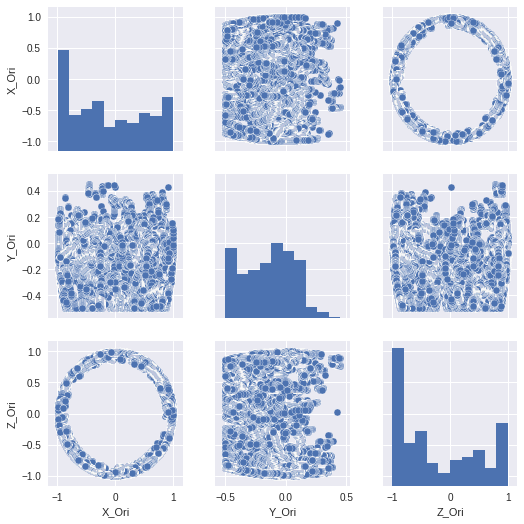

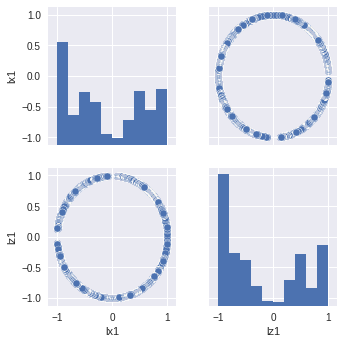

In [7]:
# plotting distribution of original X, Y and new vector
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['X_Ori', 'Y_Ori', 'Z_Ori'])


fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

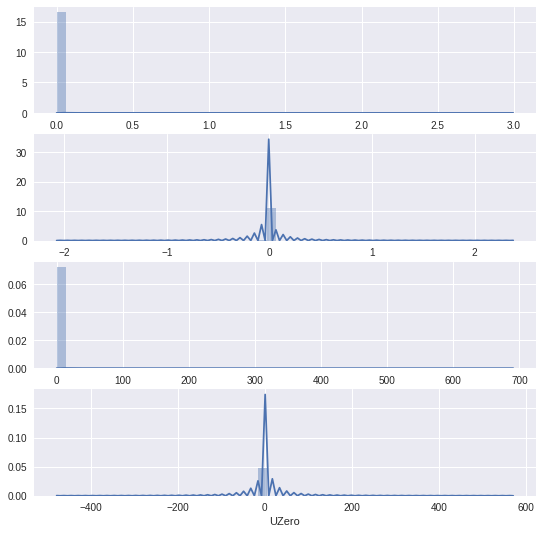

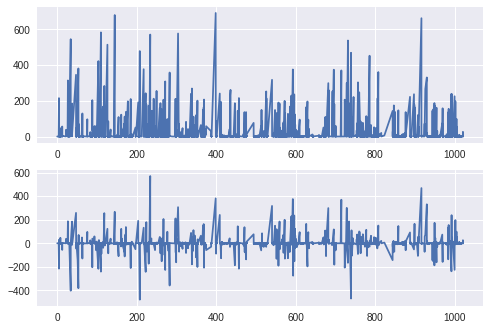

In [8]:
# U and theta distributions
i=100

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.distplot(dfV.theta    , ax=ax1)
sns.distplot(dfV.thetaZero, ax=ax2)
sns.distplot(dfV.U        , ax=ax3)
sns.distplot(dfV.UZero    , ax=ax4)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
c1 = ax1.plot(dfV.Time, dfV.U)
c2 = ax2.plot(dfV.Time, dfV.UZero)


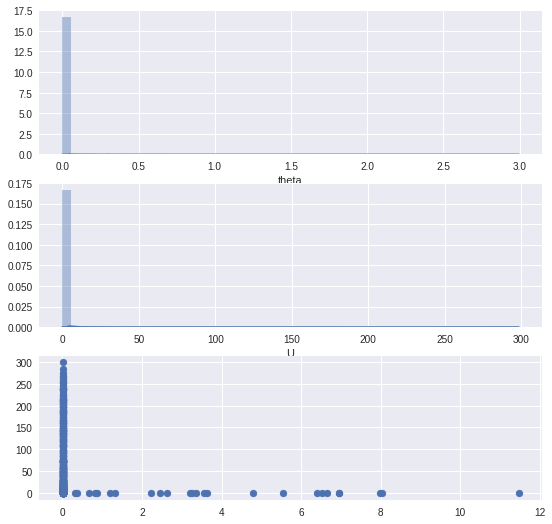

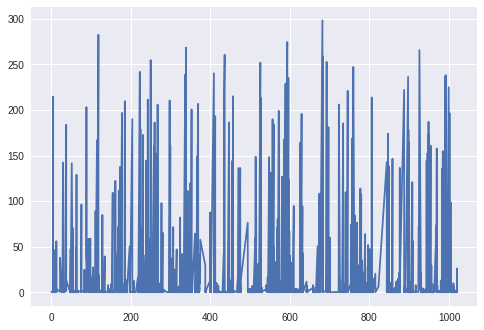

In [9]:
# U and theta distributions
dfV2 = dfV[dfV['U'] < 300]

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV2.theta, ax=ax1)
sns.distplot(dfV2.U    , ax=ax2)
ax3.scatter (dfV2.dTime, dfV2.U )

fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.plot(dfV2.Time, dfV2.U)


In [13]:
# U and theta distributions
dfV2 = dfV[dfV['UZero'] < 30]
dfV2 = dfV[dfV['UZero'] >-30]

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV2.theta, ax=ax1)
sns.distplot(dfV2.UZero, ax=ax2)
ax3.scatter (dfV2.dTime, dfV2.UZero )

fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.plot(dfV2.Time, dfV2.UZero)


KeyError: 'UZero'

## Applying the method on all experiments

In [11]:
# applying method to all experiments
for i, x in enumerate(fname):
    df[i] = pd.read_hdf(path+x+'_filter.h5', 'Full')
    
dfV = {}

for i, x in enumerate(fname):
    dfV[i] = df[i]
    #clearing data off useless variables
    dfV[i].rename(columns={"Time_Ori":'Time'}, inplace=True)
    dfV[i].drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)

    print(i, 'done')
    

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done


In [12]:
for i, x in enumerate(fname):
    # calculating lenghts of VecX and VecZ and creation of shifted vectors
    dfV[i] = dfV[i].apply(decompose_vec_df, axis=1)
    dfV[i]['V1'] = np.linalg.norm(np.array([dfV[i].lx1, 0, dfV[i].lz1]))

    # propagate the sign of a X, Z to new vector
    dfV[i]['lx1'] = dfV[i].apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
    dfV[i]['lz1'] = dfV[i].apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

    # normalize the data to unit vector form
    dfV[i]['lx1'] = dfV[i].apply(lambda row: row.lx1 / row.V1, axis=1)
    dfV[i]['lz1'] = dfV[i].apply(lambda row: row.lz1 / row.V1, axis=1)


    dfV[i]['lx2'] = dfV[i].lx1.shift(1)
    dfV[i]['lz2'] = dfV[i].lz1.shift(1)
    dfV[i].dropna(inplace=True)
    print(i, 'done')


0 done
1 done


KeyboardInterrupt: 

In [ ]:
for i, x in enumerate(fname):
    # calculating angle between two vectors - ver1
    dfV[i] = dfV[i].apply(angle_theta , axis=1)
    
    # calculating angle between two vectors - ver 2, to relative X axis
    dfV[i] = dfV[i].apply(angle_zero , axis=1)
    dfV[i]['theta1'] = dfV[i].theta0.shift(1)
    dfV[i]['thetaZero'] = dfV[i].apply(lambda row: row.theta0 - row.theta1, axis=1)
    dfV[i].drop({'theta0','theta1'}, axis=1, inplace=True)

    print(i, 'done')


In [ ]:
for i, x in enumerate(fname):
    # angular velocity
    dfV[i]['U']     = dfV[i].apply(lambda row: row.theta     / row.dTime, axis=1)
    dfV[i]['UZero'] = dfV[i].apply(lambda row: row.thetaZero / row.dTime, axis=1)
    dfV[i].dropna(inplace=True)

    print(i, 'done')    


In [ ]:
# angular velocity distribution for all experiments
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)

for i, x in enumerate(fname):
    sns.distplot(dfV[i].theta, ax=ax1)
    sns.distplot(dfV[i].U    , ax=ax2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
    
for i, x in enumerate(fname):
    ax.plot(dfV[i].Time, dfV[i].theta)

fig = plt.figure()
ax = fig.add_subplot(111)
    
for i, x in enumerate(fname):
    ax.plot(dfV[i].Time, dfV[i].U)


In [ ]:
for i, x in enumerate(fname):
    # angular velocity
    dfV[i] = dfV[i][dfV[i]['U'] < 300]

# angular velocity distribution for all experiments
fig = plt.figure(figsize=(9,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)

for i, x in enumerate(fname):
    sns.distplot(dfV[i].theta, ax=ax1)
    sns.distplot(dfV[i].U    , ax=ax2)

In [ ]:
# SAVING DATA TO FILES
path = '../datasets/analysis/'

for i, x in enumerate(fname):
    dfV[i].to_hdf(path+x+'_velocity.h5', 'Full', table=True)
